In [ ]:
!nvidia-smi

Sat Feb 13 20:25:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import tensorflow_hub as hub

import os

In [ ]:
# find file paths
food = ['apple_pie','baby_back_ribs', 'baklava'] 
f_train_path = '/content/drive/MyDrive/Colab Projects/food_3classes100Photos/train/'
f_test_path = '/content/drive/MyDrive/Colab Projects/food_3classes100Photos/test/'
f_apple = glob.glob(f_train_path + food[0]+'/*')
f_baby = glob.glob(f_train_path + food[1]+'/*')
f_baklava = glob.glob(f_train_path + food[2]+'/*')
f_apple_test = glob.glob(f_test_path + food[0]+'/*')
f_baby_test = glob.glob(f_test_path + food[1]+'/*')
f_baklava_test = glob.glob(f_test_path + food[2]+'/*')
# total 1000 files for each category
print('Number of images per class:\n\t\ttrain\ttest \nApple_pie:\t{}\t{}\nBaby_pork_ribs:\t{}\t{}\nBaklava:\t{}\t{}'
      .format(len(f_apple),len(f_apple_test),len(f_baby),len(f_baby_test),len(f_baklava),len(f_baklava_test)))

Number of images per class:
		train	test 
Apple_pie:	150	30
Baby_pork_ribs:	150	30
Baklava:	150	30


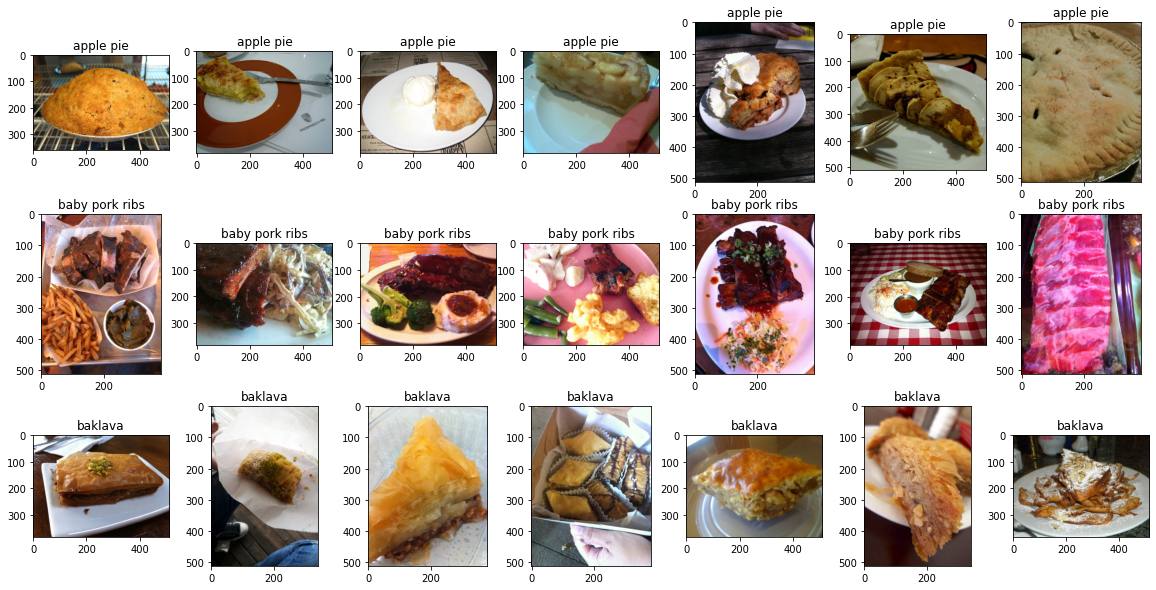

In [ ]:
# preview some images of each class
n = 7
from glob import glob
classes_number = len(glob(f_train_path + '/*'))
fig, axes = plt.subplots(classes_number,n,figsize=(20,10))

for i in range(n):
    axes[0, i].imshow(plt.imread(f_apple[i]))
    axes[0, i].set_title('apple pie')
    axes[1, i].imshow(plt.imread(f_baby[i]))
    axes[1, i].set_title('baby pork ribs')
    axes[2, i].imshow(plt.imread(f_baklava[i]))
    axes[2, i].set_title('baklava')

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255
                 )
train_generator = train_datagen.flow_from_directory( #images are loaded progressively in alphabetical order and assigned an integer for each class 
        f_train_path,
        target_size=(299,299),
        batch_size=16)
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        f_test_path,
        target_size=(299,299),
        batch_size=16)

Found 450 images belonging to 3 classes.
Found 91 images belonging to 3 classes.


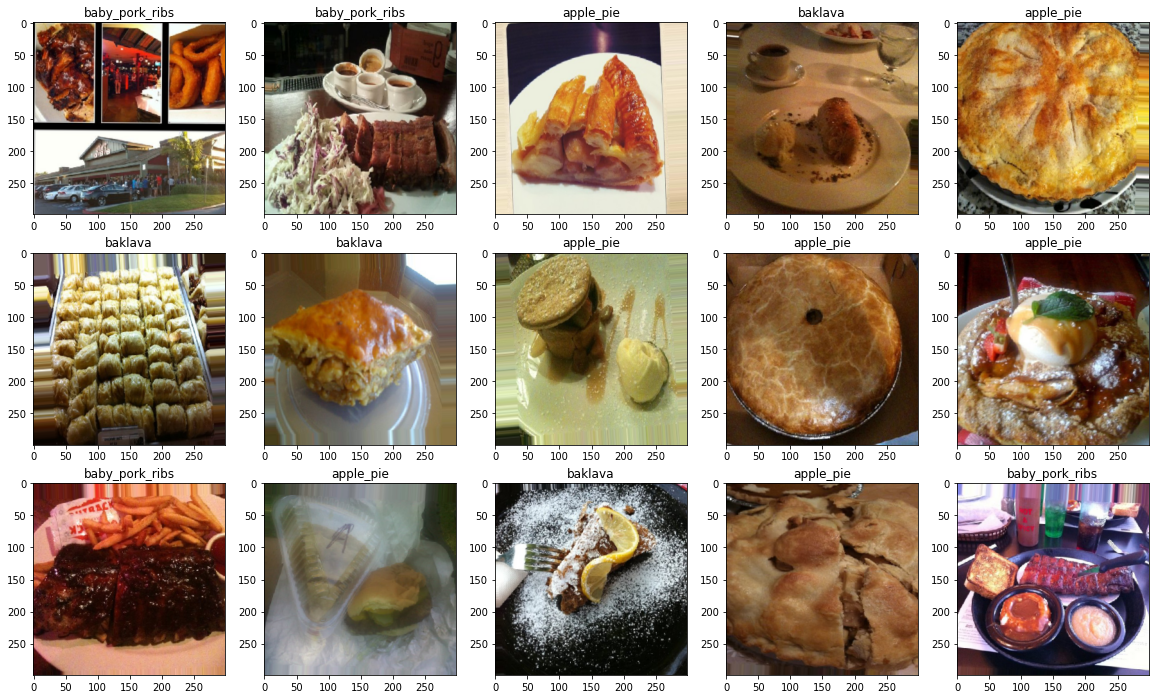

In [ ]:
# preview images from train generator
r = 3; c = 5
n=0
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava'} #alphabetical order, each class assigned an integer because of flow_from_directory() function
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

In [ ]:
nclass = len(train_generator.class_indices)
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(299, 299,3))
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='model-inceptionv3.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
train_photos = 450
test_photos = 90
batch_size = 16
history = model.fit_generator(train_generator,steps_per_epoch=train_photos/batch_size,
                              validation_data=test_generator,validation_steps=test_photos/batch_size, 
                              epochs=20, callbacks=[checkpointer, reduceLR, earlystopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
28/28 [==============================] - 11s 380ms/step - loss: 0.4201 - accuracy: 0.8333 - val_loss: 0.3884 - val_accuracy: 0.8681

Epoch 00001: val_loss did not improve from 0.37892
Epoch 2/20
28/28 [==============================] - 11s 376ms/step - loss: 0.3767 - accuracy: 0.8644 - val_loss: 0.3753 - val_accuracy: 0.9011

Epoch 00002: val_loss improved from 0.37892 to 0.37528, saving model to model-inceptionv3.hdf5
Epoch 3/20
28/28 [==============================] - 11s 380ms/step - loss: 0.3842 - accuracy: 0.8489 - val_loss: 0.3763 - val_accuracy: 0.8901

Epoch 00003: val_loss did not improve from 0.37528
Epoch 4/20
28/28 [==============================] - 11s 393ms/step - loss: 0.3717 - accuracy: 0.8622 - val_loss: 0.3830 - val_accuracy: 0.8791

Epoch 00004: val_loss did not improve from 0.37528
Epoch 5/20
28/28 [==============================] - 11s 376ms/step - loss: 0.3577 - accuracy: 0.8600 - val_loss: 0.3751 - val_accuracy: 0.9011

Epoch 00005: val_loss improved f

Trained model for 120 epochs

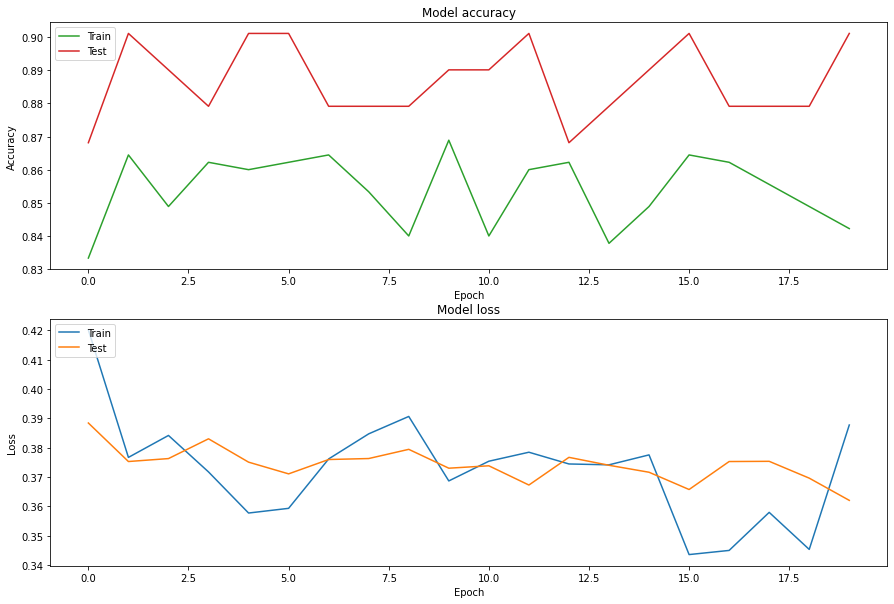

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

In [ ]:
# create another generator for all test images in a single batch (90 photos total in test)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        f_test_path,
        target_size=(299,299),
        batch_size=90)

Found 91 images belonging to 3 classes.


In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 90.0%


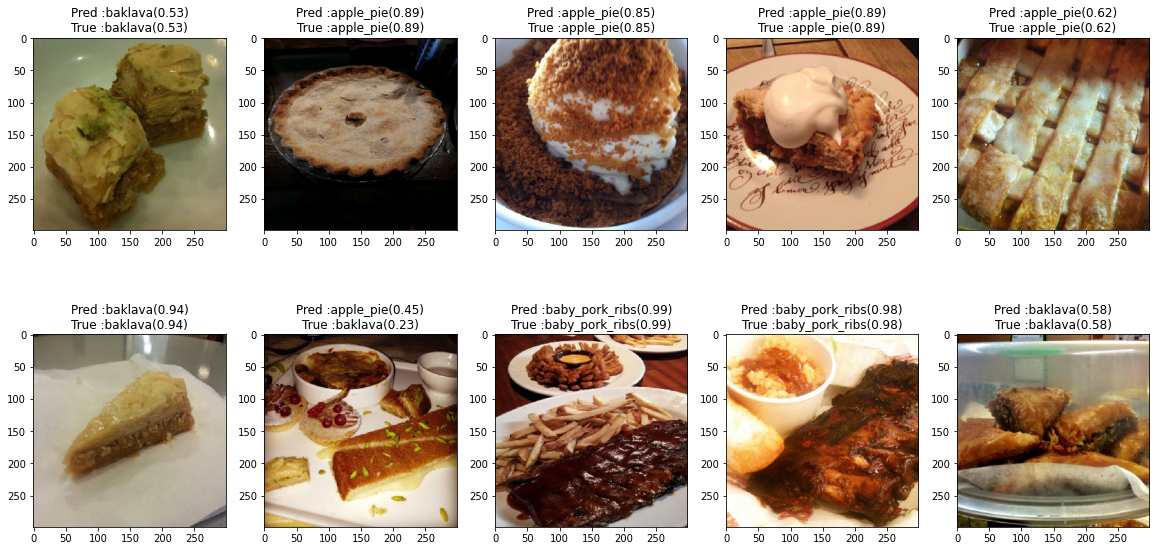

In [ ]:
#ind = np.random.randint(1,len(x_test),10)
f, ax=plt.subplots(2,5,figsize=(20,10))
#for i,j in enumerate(ind):
#for i,j in enumerate(ind):
for k in range(2):
  for l in range(5):
      j=np.random.randint(1,len(x_test))
      ax[k,l].imshow(x_test[j])
      ax[k,l].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                            (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                            classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))

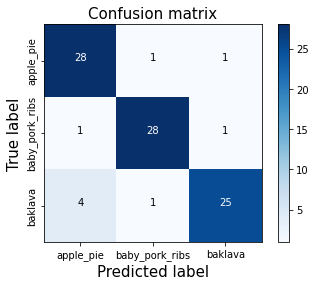

In [ ]:
def plot_confusion_matrix(cm):    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['apple_pie','baby_pork_ribs','baklava']
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0,1,2], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

In [ ]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 3
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

In [ ]:
show_wrongest_label(x_test,y_test,y_pred_conf)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/inceptionv3_model.h5"
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/Colab Projects/inceptionv3_model.h5


In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/inceptionv3_model.h5"
reloaded = load_model( #or just load_model because the package is imported already
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

array([[0.29829064, 0.2667939 , 0.43491548]], dtype=float32)

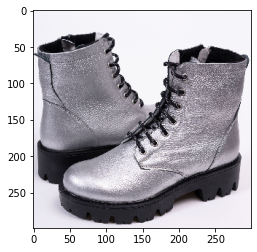

In [ ]:
#make a threshold such that, only if the model is at least 50% sure that the object is food then food exists in the picture
img=load_img('/content/drive/MyDrive/Colab Projects/food_3classes100Photos/ghete.jpg',target_size=(299,299))
plt.imshow(img)
img = np.array(img).astype('float32')/255
#print(img.shape)
img = np.expand_dims(img, axis=0)
#img.shape
reloaded.predict(img)

In [ ]:
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava'}
result = reloaded.predict(img)
maximum = np.max(result)
y_pred = np.argmax(result,axis=1)
if maximum >= 0.5: #apply threshold of 40% 
  print(classtolabel[str(y_pred[0])])
else:
  print('the model is not sure if there is even food in the picture')

the model is not sure if there is even food in the picture
